<a href="https://colab.research.google.com/github/LucianaAngrisano/TriagemProcessual/blob/main/AU_XGBOOST_3_classes_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Teste Modelo XGBoost

# Caderno Jupyter

In [1]:
#!pip install xgboost

In [2]:
#!pip install imblearn

In [3]:
# vitor
#from pathlib import Path
#pasta_projeto = Path(Path.cwd())

In [4]:
#Luciana

# ver a localização do caderno no computador:
# %pwd

# importa biblioteca para referenciar pasta:
# from pathlib import Path
# pasta_projeto = Path('C:\\Users\\luciana.angrisano\\Downloads\\Projeto-20211210T192757Z-001\\Projeto')

# Obtenção do dataframe

In [5]:
#monta o Google Drive para acesso pelo Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
# Cria objeto com o caminho da pasta do Projeto
from pathlib import Path
pasta_projeto = Path('drive/MyDrive/Colab Notebooks/Projeto')

In [7]:
# Cria o DataFrame apartir dos dados salvos no primeiro Caderno
import pandas as pd
df = pd.read_parquet(pasta_projeto / 'AU final.parquet')
print(df.shape)
df.head(3)
df['Setor_Sigla'].value_counts()

(14520, 4)


COREJEF1R    10106
CORESA1R      2457
CORESP1R      1266
CORESE1R       394
COREM1R        124
CORAT1R         94
COREPAM1R       79
Name: Setor_Sigla, dtype: int64

In [8]:
df

,peticao,Tipo_Assunto_Nome,Setor_Sigla,Classe_Processo_Nome
0,Petição segue anexa.\n \nNum. 751512049 - Pág....,AVERBAÇÃO / CONTAGEM DE TEMPO ESPECIAL,COREJEF1R,RECURSO INOMINADO
1,9254-20.2010.4.01.3803 \nEXMO (A) SR (A) JUIZ ...,FORNECIMENTO DE MEDICAMENTOS,CORESA1R,RECURSO INOMINADO
2,Dados sobre a doença e medicamento(s)/exame(s)...,PADRONIZADO,CORESA1R,RECURSO INOMINADO
3,inicial\n \nNum. 409309388 - Pág. 1Assinado el...,SEGURO-DESEMPREGO,COREJEF1R,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL
4,INICIAL\n \nNum. 409362388 - Pág. 1Assinado el...,SEGURO-DESEMPREGO,COREJEF1R,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL
...,...,...,...,...
15040,Petição recebida e distribuída nesta seção con...,PADRONIZADO,CORESA1R,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL
15041,Petição recebida e distribuída nesta seção con...,PADRONIZADO,CORESA1R,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL
15042,Segue inicial e documentos.\n \nNum. 751565069...,EXAME DE SAÚDE E/OU APTIDÃO FÍSICA,CORESP1R,MANDADO DE SEGURANÇA
15043,INICIAL\n \nNum. 752882994 - Pág. 1Assinado el...,SEGURO-DESEMPREGO,COREJEF1R,PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL


# Separação das variáveis independentes e depentende (TARGET)

In [9]:
# define variaveis independentes e variável dependente(TARGET)
X = df[['peticao','Tipo_Assunto_Nome','Classe_Processo_Nome']]
y = df['Setor_Sigla']

# Codificação das variáveis independentes (categórica + texto)

In [10]:
# Transformação das variáveis independentes categórica para numérica
X_train_dum = pd.get_dummies(X[['Tipo_Assunto_Nome','Classe_Processo_Nome']])
X_train_dum.shape

(14520, 443)

In [11]:
# mostra o dataframe da variável texto com as variáveis categóricas já tratadas
X = pd.concat([X['peticao'], X_train_dum], axis=1)
X.head()

,peticao,Tipo_Assunto_Nome_ CONCURSO DE MILITAR,Tipo_Assunto_Nome_ PRAZO,Tipo_Assunto_Nome_1/3 DE FÉRIAS,Tipo_Assunto_Nome_ABATIMENTO PROPORCIONAL DO PREÇO,Tipo_Assunto_Nome_ABONO DA LEI 8.178/91,Tipo_Assunto_Nome_ABONO DE PERMANÊNCIA,Tipo_Assunto_Nome_ABONO DE PERMANÊNCIA EM SERVIÇO (ART. 87),Tipo_Assunto_Nome_ABONO PECUNIÁRIO (ART. 78 LEI 8.112/1990),Tipo_Assunto_Nome_ACIDENTE DE TRÂNSITO,Tipo_Assunto_Nome_ACOMPANHAMENTO DE CÔNJUGE OU COMPANHEIRO,Tipo_Assunto_Nome_ACUMULAÇÃO DE CARGOS,Tipo_Assunto_Nome_ACUMULAÇÃO DE PROVENTOS,Tipo_Assunto_Nome_ADICIONAL DE FRONTEIRA,Tipo_Assunto_Nome_ADICIONAL DE HORAS EXTRAS,Tipo_Assunto_Nome_ADICIONAL DE INSALUBRIDADE,Tipo_Assunto_Nome_ADICIONAL DE PRODUTIVIDADE,Tipo_Assunto_Nome_ADICIONAL DE SERVIÇO NOTURNO,Tipo_Assunto_Nome_ADICIONAL DE TARIFA AEROPORTUÁRIA,Tipo_Assunto_Nome_ADICIONAL POR TEMPO DE SERVIÇO,Tipo_Assunto_Nome_ADIMPLEMENTO E EXTINÇÃO,Tipo_Assunto_Nome_ADJUDICAÇÃO,Tipo_Assunto_Nome_ADMISSÃO / PERMANÊNCIA / DESPEDIDA,Tipo_Assunto_Nome_ADVERTÊNCIA,Tipo_Assunto_Nome_ADVERTÊNCIA / REPREENSÃO,Tipo_Assunto_Nome_AGREGAÇÃO,Tipo_Assunto_Nome_AGÊNCIAS/ÓRGÃOS DE REGULAÇÃO,Tipo_Assunto_Nome_AGÊNCIE E DISTRIBUIÇÃO,Tipo_Assunto_Nome_ALIENAÇÃO FIDUCIÁRIA,Tipo_Assunto_Nome_ALTERAÇÃO DO COEFICIENTE DE CÁLCULO DE PENSÃO,Tipo_Assunto_Nome_ALTERAÇÃO DO COEFICIENTE DE CÁLCULO DO BENEFÍCIO,Tipo_Assunto_Nome_AMBIENTAL,Tipo_Assunto_Nome_ANISTIA ADMINISTRATIVA,Tipo_Assunto_Nome_ANISTIA POLÍTICA,Tipo_Assunto_Nome_ANULAÇÃO,Tipo_Assunto_Nome_ANULAÇÃO E CORREÇÃO DE PROVAS / QUESTÕES,Tipo_Assunto_Nome_APLICAÇÃO DE COEFICIENTE DE CÁLCULO DIVERSO DO FIXADO NA LEI N.º 8.213/91,Tipo_Assunto_Nome_APOSENTADORIA,Tipo_Assunto_Nome_APOSENTADORIA / PENSÃO ESPECIAL,Tipo_Assunto_Nome_APOSENTADORIA ESPECIAL (ART. 57/8),...,Classe_Processo_Nome_AÇÃO CIVIL PÚBLICA,Classe_Processo_Nome_AÇÃO POPULAR,Classe_Processo_Nome_CARTA PRECATÓRIA CRIMINAL,Classe_Processo_Nome_CARTA PRECATÓRIA CÍVEL,Classe_Processo_Nome_CONSIGNATÓRIA DE ALUGUÉIS,Classe_Processo_Nome_CONSIGNAÇÃO EM PAGAMENTO,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE DECISÃO,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE SENTENÇA,Classe_Processo_Nome_DESAPROPRIAÇÃO,Classe_Processo_Nome_EMBARGOS DE TERCEIRO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO FISCAL,Classe_Processo_Nome_EXECUÇÃO CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_EXECUÇÃO DE TÍTULO EXTRAJUDICIAL,Classe_Processo_Nome_EXECUÇÃO FISCAL,Classe_Processo_Nome_EXIBIÇÃO DE DOCUMENTO OU COISA,Classe_Processo_Nome_HABEAS DATA,Classe_Processo_Nome_HOMOLOGAÇÃO DE TRANSAÇÃO EXTRAJUDICIAL,Classe_Processo_Nome_IMISSÃO NA POSSE,Classe_Processo_Nome_INCIDENTE DE DESCONSIDERAÇÃO DE PERSONALIDADE JURÍDICA,Classe_Processo_Nome_INQUÉRITO POLICIAL,Classe_Processo_Nome_INTERDITO PROIBITÓRIO,Classe_Processo_Nome_LIQUIDAÇÃO POR ARTIGOS,Classe_Processo_Nome_LIQUIDAÇÃO PROVISÓRIA POR ARTIGOS,Classe_Processo_Nome_MANDADO DE SEGURANÇA,Classe_Processo_Nome_MANDADO DE SEGURANÇA COLETIVO,Classe_Processo_Nome_MONITÓRIA,Classe_Processo_Nome_OUTROS PROCEDIMENTOS DE JURISDIÇÃO VOLUNTÁRIA,Classe_Processo_Nome_PETIÇÃO,Classe_Processo_Nome_PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Classe_Processo_Nome_PROCEDIMENTO ORDINÁRIO,Classe_Processo_Nome_PRODUÇÃO ANTECIPADA DE PROVAS,Classe_Processo_Nome_PROTESTO,Classe_Processo_Nome_RECURSO INOMINADO,Classe_Processo_Nome_REINTEGRAÇÃO / MANUTENÇÃO DE POSSE,Classe_Processo_Nome_TUTELA ANTECIPADA ANTECEDENTE,Classe_Processo_Nome_TUTELA CAUTELAR ANTECEDENTE,Classe_Processo_Nome_USUCAPIÃO
0,Petição segue anexa.\n \nNum. 751512049 - Pág....,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
1,9254-20.2010.4.01.3803 \nEXMO (A) SR (A) JUIZ ...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0

In [12]:
# importação das bibliotecas necessárias para tratamento da variável de texto
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [13]:
# importação das bibliotecas necessárias para treino e teste do modelo e métricas
from xgboost import XGBClassifier
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import f1_score

In [14]:
# Separação dos dados de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.20, random_state=42)

In [15]:
# Tratamento dos dados de treino textual 
tfidf = TfidfVectorizer(stop_words=stopwords.words('portuguese'), min_df=3, max_df=0.70, max_features=1000)

# Aprende vocabulário e idf do conjunto de treinamento
tfidf.fit(X_train['peticao'])

# Transforma documentos em matriz termo-documento
X_train_tfidf = tfidf.transform(X_train['peticao'])
X_test_tfidf = tfidf.transform(X_test['peticao'])

In [16]:
# tratamento do test
# após a transformação do texto usamos o todense para armazenar valores ausentes na série (quando nao encontrou a palavra na petição retornou "naN")
X_test_tfidf = pd.DataFrame(X_test_tfidf.todense())
X_test_tfidf.index = X_test.index

In [17]:
# função concat para retirar a coluna de texto da petição , axis = 1 concatena colunas axis = 0 concatena linhas
X_test = pd.concat([X_test_tfidf, X_test.drop(columns='peticao')], axis=1)
X_test.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,Classe_Processo_Nome_AÇÃO CIVIL PÚBLICA,Classe_Processo_Nome_AÇÃO POPULAR,Classe_Processo_Nome_CARTA PRECATÓRIA CRIMINAL,Classe_Processo_Nome_CARTA PRECATÓRIA CÍVEL,Classe_Processo_Nome_CONSIGNATÓRIA DE ALUGUÉIS,Classe_Processo_Nome_CONSIGNAÇÃO EM PAGAMENTO,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE DECISÃO,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE SENTENÇA,Classe_Processo_Nome_DESAPROPRIAÇÃO,Classe_Processo_Nome_EMBARGOS DE TERCEIRO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO FISCAL,Classe_Processo_Nome_EXECUÇÃO CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_EXECUÇÃO DE TÍTULO EXTRAJUDICIAL,Classe_Processo_Nome_EXECUÇÃO FISCAL,Classe_Processo_Nome_EXIBIÇÃO DE DOCUMENTO OU COISA,Classe_Processo_Nome_HABEAS DATA,Classe_Processo_Nome_HOMOLOGAÇÃO DE TRANSAÇÃO EXTRAJUDICIAL,Classe_Processo_Nome_IMISSÃO NA POSSE,Classe_Processo_Nome_INCIDENTE DE DESCONSIDERAÇÃO DE PERSONALIDADE JURÍDICA,Classe_Processo_Nome_INQUÉRITO POLICIAL,Classe_Processo_Nome_INTERDITO PROIBITÓRIO,Classe_Processo_Nome_LIQUIDAÇÃO POR ARTIGOS,Classe_Processo_Nome_LIQUIDAÇÃO PROVISÓRIA POR ARTIGOS,Classe_Processo_Nome_MANDADO DE SEGURANÇA,Classe_Processo_Nome_MANDADO DE SEGURANÇA COLETIVO,Classe_Processo_Nome_MONITÓRIA,Classe_Processo_Nome_OUTROS PROCEDIMENTOS DE JURISDIÇÃO VOLUNTÁRIA,Classe_Processo_Nome_PETIÇÃO,Classe_Processo_Nome_PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Classe_Processo_Nome_PROCEDIMENTO ORDINÁRIO,Classe_Processo_Nome_PRODUÇÃO ANTECIPADA DE PROVAS,Classe_Processo_Nome_PROTESTO,Classe_Processo_Nome_RECURSO INOMINADO,Classe_Processo_Nome_REINTEGRAÇÃO / MANUTENÇÃO DE POSSE,Classe_Processo_Nome_TUTELA ANTECIPADA ANTECEDENTE,Classe_Processo_Nome_TUTELA CAUTELAR ANTECEDENTE,Classe_Processo_Nome_USUCAPIÃO
705,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.158621,0.000000,0.000000,0.000000,0.000000,0.0,0.106575,0.0,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.135232,0.0,0.000000,0.000000,0.00000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
11403,0.013298,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.051174,0.000000,0.106095,0.000000,0.000000,0.0,0.005494,0.101082,0.005764,0.087866,0.006052,0.005323,0.0,0.009433,0.0,0.000000,0.004973,0.0,0.000000,0.019222,0.000000,0.000000,0.000000,0.000000,0.032251,0.004488,0.0,0.000000,0.000000,0.00000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
6838,0.012017,0.000000,0.017321,0.0,0.0,0.000000,0.000000,0.000000,0.013168,0.000000,0.000000,0.000000,0.020777,0.092266,0.0,0.000000,0.011418,0.000000,0.011343,0.000000,0.014432,0.0,0.012786,0.0,0.227372,0.026966,0.0,0.000000,0.000000,0.046038,0.020946,0.000000,0.000000,0.024981,0.012168,0.0,0.000000,0.000000,0.00000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
12871,0.000000,0.041613,0.000000,0.0,0.0,0.031270,0.000000,0.114328,0.000000,0.113452,0.019910,0.013177,0.009994,0.000000,0.0,0.007165,0.192238,0.007517,0.021826,0.007893,0.000000,0.0,0.000000,0.0,0.012867,0.006486,0.0,0.005932,0.000000,0.000000,0.000000,0.063788,0.008935,0.006008,0.000000,0.0,0.020238,0.044932,0.00000,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5279,0.040511,0.000000,0.000000,0.0,0.0,0.021914,0.022463,0.000000,0.000000,0.000000,0.093016,0.438626,0.000000,0.088865,0.0,0.000000,0.000000,0.000000,0.076477,0.000000,0.000000,0.0,0.021551,0.0,0.067629,0.090901,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.03746,0.0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0

In [18]:
# tratamento dos dados do treino
X_train_tfidf = pd.DataFrame(X_train_tfidf.todense())
X_train_tfidf.index = X_train.index

In [19]:
# tratamento dos dados do treino
X_train = pd.concat([X_train_tfidf, X_train.drop(columns='peticao')], axis=1)
X_train.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,Classe_Processo_Nome_AÇÃO CIVIL PÚBLICA,Classe_Processo_Nome_AÇÃO POPULAR,Classe_Processo_Nome_CARTA PRECATÓRIA CRIMINAL,Classe_Processo_Nome_CARTA PRECATÓRIA CÍVEL,Classe_Processo_Nome_CONSIGNATÓRIA DE ALUGUÉIS,Classe_Processo_Nome_CONSIGNAÇÃO EM PAGAMENTO,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA,Classe_Processo_Nome_CUMPRIMENTO DE SENTENÇA CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE DECISÃO,Classe_Processo_Nome_CUMPRIMENTO PROVISÓRIO DE SENTENÇA,Classe_Processo_Nome_DESAPROPRIAÇÃO,Classe_Processo_Nome_EMBARGOS DE TERCEIRO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO,Classe_Processo_Nome_EMBARGOS À EXECUÇÃO FISCAL,Classe_Processo_Nome_EXECUÇÃO CONTRA A FAZENDA PÚBLICA,Classe_Processo_Nome_EXECUÇÃO DE TÍTULO EXTRAJUDICIAL,Classe_Processo_Nome_EXECUÇÃO FISCAL,Classe_Processo_Nome_EXIBIÇÃO DE DOCUMENTO OU COISA,Classe_Processo_Nome_HABEAS DATA,Classe_Processo_Nome_HOMOLOGAÇÃO DE TRANSAÇÃO EXTRAJUDICIAL,Classe_Processo_Nome_IMISSÃO NA POSSE,Classe_Processo_Nome_INCIDENTE DE DESCONSIDERAÇÃO DE PERSONALIDADE JURÍDICA,Classe_Processo_Nome_INQUÉRITO POLICIAL,Classe_Processo_Nome_INTERDITO PROIBITÓRIO,Classe_Processo_Nome_LIQUIDAÇÃO POR ARTIGOS,Classe_Processo_Nome_LIQUIDAÇÃO PROVISÓRIA POR ARTIGOS,Classe_Processo_Nome_MANDADO DE SEGURANÇA,Classe_Processo_Nome_MANDADO DE SEGURANÇA COLETIVO,Classe_Processo_Nome_MONITÓRIA,Classe_Processo_Nome_OUTROS PROCEDIMENTOS DE JURISDIÇÃO VOLUNTÁRIA,Classe_Processo_Nome_PETIÇÃO,Classe_Processo_Nome_PROCEDIMENTO DO JUIZADO ESPECIAL CÍVEL,Classe_Processo_Nome_PROCEDIMENTO ORDINÁRIO,Classe_Processo_Nome_PRODUÇÃO ANTECIPADA DE PROVAS,Classe_Processo_Nome_PROTESTO,Classe_Processo_Nome_RECURSO INOMINADO,Classe_Processo_Nome_REINTEGRAÇÃO / MANUTENÇÃO DE POSSE,Classe_Processo_Nome_TUTELA ANTECIPADA ANTECEDENTE,Classe_Processo_Nome_TUTELA CAUTELAR ANTECEDENTE,Classe_Processo_Nome_USUCAPIÃO
3470,0.044333,0.000000,0.000000,0.000000,0.0,0.015988,0.000000,0.204584,0.000000,0.000000,0.000000,0.000000,0.025550,0.000000,0.027215,0.000000,0.000000,0.000000,0.097642,0.000000,0.124228,0.0,0.015723,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.028306,0.0000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0
8186,0.032730,0.000000,0.047173,0.000000,0.0,0.017705,0.018148,0.032365,0.000000,0.000000,0.000000,0.000000,0.000000,0.143593,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.034824,0.000000,0.036427,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.000000,0.016570,0.052963,0.00000,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
13548,0.000000,0.000000,0.000000,0.000000,0.0,0.012539,0.032132,0.017191,0.019049,0.006690,0.325981,0.019813,0.000000,0.006356,0.021344,0.007182,0.016518,0.007535,0.032819,0.007912,0.006959,0.0,0.036993,0.000000,0.006449,0.006501,0.000000,0.017840,0.012564,0.000000,0.0101,0.000000,0.008957,0.018069,0.058675,0.000000,0.00000,0.033781,0.000000,0.024811,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3129,0.016553,0.006349,0.006258,0.016212,0.0,0.071634,0.029492,0.023346,0.148373,0.148808,0.029596,0.022578,0.006568,0.018156,0.004498,0.002691,0.038675,0.001411,0.047130,0.001482,0.034870,0.0,0.157644,0.019493,0.039564,0.017658,0.007753,0.021164,0.000588,0.010915,0.0000,0.000998,0.000839,0.003667,0.020058,0.002635,0.00095,0.003691,0.006022,0.016266,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
5003,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000

# Treino e teste do modelo (sem o balancceamento)

In [20]:
# importa o modelo XGBOOST
from xgboost import XGBClassifier

# instancia o modelo
model = XGBClassifier()

# treina e testa o modelo
model.fit(X_train, y_train)
model.score(X_test, y_test)

0.9820936639118457

In [21]:
#importou a biblioteca para medir a acurácia balanceada
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(y_test, model.predict(X_test)))

0.8566937974833568


In [22]:
# importa a biblioteca para visualização das métricas
from sklearn.metrics import classification_report
print(classification_report(y_test, model.predict(X_test)))

              precision    recall  f1-score   support

     CORAT1R       0.87      0.68      0.76        19
   COREJEF1R       1.00      1.00      1.00      2021
     COREM1R       0.85      0.88      0.86        25
   COREPAM1R       0.91      0.62      0.74        16
    CORESA1R       0.96      0.99      0.97       491
    CORESE1R       0.91      0.89      0.90        79
    CORESP1R       0.95      0.94      0.94       253

    accuracy                           0.98      2904
   macro avg       0.92      0.86      0.88      2904
weighted avg       0.98      0.98      0.98      2904



# Matriz de Confusão (sem o balanceamento)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


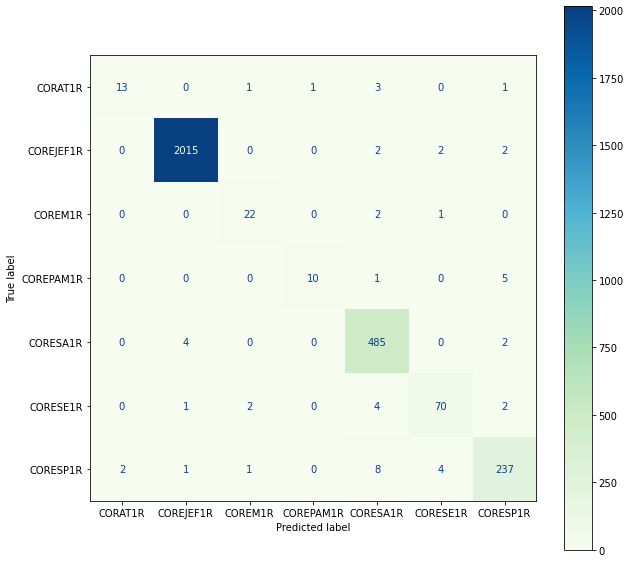

In [23]:
#importa a biblioteca para plotar a matriz de confusão
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
# define o tamanho do gráfico
fig, ax = plt.subplots(figsize=(10,10))
#plota a matriz de confusão passando os parâmetros do modelo, das variáveis e do tamanho do gráfico definidio anteriormente
plot_confusion_matrix(model, X_test, y_test, ax=ax, cmap='GnBu');

# Balanceamento das classes

In [24]:
# importa a biblioteca para balancear a variável target
from imblearn.over_sampling import RandomOverSampler

# para equilibrar o conjunto de dados que estão com pouca amostragem
# apenas nos dados de treino
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1679: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


#Treino e teste do Modelo BALANCEADO

In [25]:
# importa o modelo XGBOOST
from xgboost import XGBClassifier

#instancia o modelo com as classes balanceadas
model_resampled = XGBClassifier()

# Treina o modelo com os dados balanceados
model_resampled.fit(X_resampled, y_resampled)

 # mostra a acurácia normal
model_resampled.score(X_resampled, y_resampled)

0.9954589628059016

In [26]:
# mostra o valor da acurácia balanceada separadamente = macro avg do Classification Report
from sklearn.metrics import balanced_accuracy_score
print(balanced_accuracy_score(y_test, model_resampled.predict(X_test)))

0.8869895358947721


In [27]:
# mostra a recall e macro avg = acurácia  (tabela)
from sklearn.metrics import classification_report
print(classification_report(y_test, model_resampled.predict(X_test)))

              precision    recall  f1-score   support

     CORAT1R       0.64      0.74      0.68        19
   COREJEF1R       1.00      0.99      1.00      2021
     COREM1R       0.71      0.88      0.79        25
   COREPAM1R       0.63      0.75      0.69        16
    CORESA1R       0.97      0.99      0.98       491
    CORESE1R       0.82      0.96      0.88        79
    CORESP1R       0.96      0.90      0.93       253

    accuracy                           0.98      2904
   macro avg       0.82      0.89      0.85      2904
weighted avg       0.98      0.98      0.98      2904



#Matriz de Confusão com os dados balanceados

> Bloco com recuo



/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)


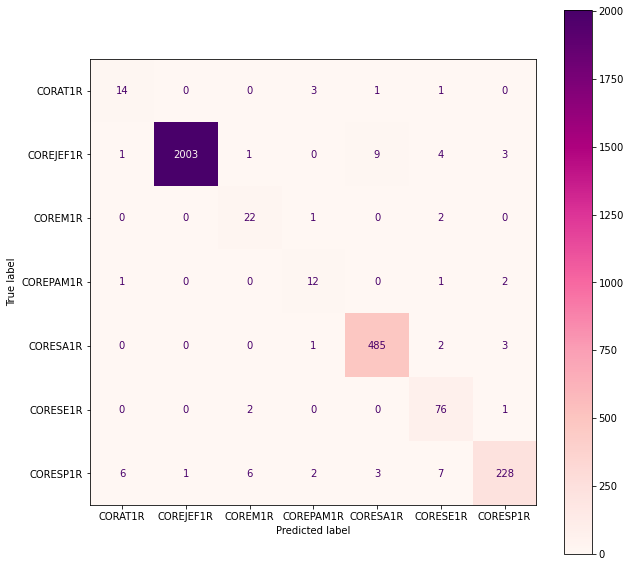

In [28]:
#importa a biblioteca para plotar a matriz de confusão
import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
# define o tamanho do gráfico
fig, ax = plt.subplots(figsize=(10,10))
#plota a matriz de confusão passando os parâmetros do modelo, das variáveis e do tamanho do gráfico definidio anteriormente
plot_confusion_matrix(model_resampled, X_test, y_test, ax=ax, cmap='RdPu');

# GridSearch para definição dos melhores hiperparâmetros

In [29]:
#from sklearn.model_selection import GridSearchCV
#profundidade da arvore, a cada nova arvore qual % do numero de registros, qual o % do n de colunas a cada nova arvore
#model = XGBClassifier()


#params = {'max_depth':[3,5,7],'subsample':[0.7,0.8,1],'colsample_bytree':[0.7,0.8,1]}

#grid_search = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1, cv=4, scoring='balanced_accuracy',error_score=0, verbose = 100)
#grid_search.fit(X_resampled,y_resampled)
#grid_search.best_params_


In [ ]:
# importa KNN e Classification report
from sklearn.metrics import classification_report
from xgboost import XGBClassifier

# modelo treinado após definição dos melhores hiperparâmetros após GridSearch = colsample_bytree=0.8, max_depth=5, subsample=1
modelfinal = XGBClassifier(colsample_bytree=0.8, max_depth=5, subsample=1)
modelfinal.fit(X_resampled,y_resampled)
modelfinal.score(X_test, y_test)
print(classification_report(y_test, modelfinal.predict(X_test)))

# Matriz de Confusão com os dados balanceados e hiperparâmetros do GridSearch

In [ ]:

import matplotlib.pyplot as plt
from sklearn.metrics import plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10,10))
plot_confusion_matrix(modelfinal, X_test, y_test, ax=ax, cmap='RdPu');

# Cross Validation com k-fold balanceado

In [ ]:
# importa biblioteca para funções matemáticas
import numpy as np

# importa bilbioteca para separar os dados em grupos com randomização diferente em cada repetição (n vezes)
# garante um percentual equivalente de dados de cada classe em cada partição 
from sklearn.model_selection import RepeatedStratifiedKFold

# importa biblioteca para balancear classes desbalanceadas
from imblearn.over_sampling import RandomOverSampler

# importa bilbioteca das métricas
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

# cria listas para receber dados (array)
ba = []
f1 = []
acc = []

# intancia o "cross validation"
rskf = RepeatedStratifiedKFold(n_splits=10, n_repeats=2, random_state=42)

# para cada train e test index ele roda a função rskf e trata, treina e testa o modelo 
for train_index, test_index in rskf.split(X, y):
  
  X_train, X_test = X.iloc[train_index], X.iloc[test_index]
  y_train, y_test = y.iloc[train_index], y.iloc[test_index]

  tfidf = TfidfVectorizer(stop_words=stopwords.words('portuguese'), min_df=3, max_df=0.70, max_features=1000)
  tfidf.fit(X_train['peticao'])

  X_train_tfidf = tfidf.transform(X_train['peticao'])
  X_test_tfidf = tfidf.transform(X_test['peticao'])

  X_test_tfidf = pd.DataFrame(X_test_tfidf.todense())
  X_test_tfidf.index = X_test.index
  X_test = pd.concat([X_test_tfidf, X_test.drop(columns='peticao')], axis=1)
  X_train_tfidf = pd.DataFrame(X_train_tfidf.todense())
  X_train_tfidf.index = X_train.index
  X_train = pd.concat([X_train_tfidf, X_train.drop(columns='peticao')], axis=1)  

  ros = RandomOverSampler(random_state=42)
  X_resampled, y_resampled = ros.fit_resample(X_train, y_train)


  model_resampled = XGBClassifier(colsample_bytree=0.8, max_depth=5, subsample=1, eval_metric='mlogloss', use_label_encoder=True)
  model_resampled.fit(X_resampled, y_resampled)

# calcula as métricas n vezes por causa do for
  ba_score = balanced_accuracy_score(y_test, model_resampled.predict(X_test))
  score_do_f1 = f1_score(y_test, model_resampled.predict(X_test), average='macro')
  acc_score = accuracy_score(y_test, model_resampled.predict(X_test))

# alimenta a lista (array) n vezespor causa do for 
  ba.append(ba_score)
  f1.append(score_do_f1)
  acc.append(acc_score)
  
  print(ba_score)
  print(score_do_f1)
  print(acc_score)
  print("TRAIN:", train_index, "TEST:", test_index)

In [ ]:
#calcula a média e o desvio padrão das métricas
# import warnings
# warnings.filter_warnings('ignore')
print(np.mean(ba))
print(np.std(ba))

In [ ]:
#calcula a média e o desvio padrão das métricas
print(np.mean(f1))
print(np.std(f1))

In [ ]:
#calcula a média e o desvio padrão das métricas
print(np.mean(acc))
print(np.std(acc))

# Importância das variáveis (não se aplica para variável texto)

In [ ]:
# tentativa de mostrar graficamente a importância das variáveis

##%%time
# Calcula a importância das variáveis
# Import a biblioteca (permutation_importance)
#from sklearn.inspection import permutation_importance
# Calcular os resultados (permutation_importance) da queda no desempenho do modelo 
#          ao embaralhar cada uma das variáveis.
#result = permutation_importance(model, X_test, y_test, n_repeats=5, random_state=42, n_jobs=-1)
# Ordenar os resultados
#sorted_idx = result.importances_mean.argsort()
# Gráfico boxplot pra mostrar a importância das variáveis
#fig, ax = plt.subplots()
# ax.boxplot(result.importances[sorted_idx].T, vert=False, labels=X_test.columns[sorted_idx])
# ax.set_title("Permutation Importances (test set)")
# fig.tight_layout()
# plt.show()